# Project 1: Astronomy Wordle Game  
*Authors: Eling Cheng and Allison Trusko*   

---

## 📌 Introduction
In this project, we implement a **Wordle-style game** using astronomy terms.  
Players guess 5-letter astronomy words with feedback given in color-coded form (green, yellow, gray).  

Goals:
- Demonstrate Python skills from **Weeks 1–4** (OOP, data structures, file I/O, NumPy, Matplotlib).
- Show how fundamental programming tools can build a useful educational game.
- Track player statistics across multiple games.  

---

## 🎮 How to Play
- You have **6 attempts** to guess the secret word.
- Feedback after each guess:
  - 🟩 = correct letter in the correct spot  
  - 🟨 = letter is in the word but wrong spot  
  - ⬜ = letter not in the word  
- After 3 failed guesses, you’ll receive a **subtle astronomy hint from Claude AI**.

---

## 🔍 Features
- Difficulty levels: **Easy / Medium / Hard**  
- Color-coded feedback like Wordle  
- Claude AI integration for hints  
- External `.txt` files for word lists (easy to expand or customize)



We will first start by loading in the API key, as shown below

In [81]:
%matplotlib inline
!pip install python-dotenv anthropic

import os
import random
from dotenv import load_dotenv
from IPython.display import display, Markdown
from anthropic import Anthropic

# Load environment variables
load_dotenv()
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

if not ANTHROPIC_API_KEY:
    print("⚠️ Missing Anthropic API key! Add it to your .env file as ANTHROPIC_API_KEY=your_key_here")

In [82]:
class PlayerStats:
    def __init__(self):
        # guess_distribution: number of times player guessed 1–6 + losses
        self.data = {
            "guess_distribution": [0, 0, 0, 0, 0, 0, 0],  # 1–6 guesses + losses
            "wins": 0,
            "losses": 0
        }

    def record_game(self, attempts, won):
        """
        Update stats after a game.
        - attempts: number of guesses used (1–6)
        - won: True if player won, False if lost
        """
        if won:
            self.data["guess_distribution"][attempts - 1] += 1
            self.data["wins"] += 1
        else:
            self.data["guess_distribution"][-1] += 1  # losses slot
            self.data["losses"] += 1

    def plot_histogram(self):
        import matplotlib.pyplot as plt
        import numpy as np

        dist = np.array(self.data["guess_distribution"], dtype=int)
        labels = ["1","2","3","4","5","6","Losses"]

        total_wins = self.data["wins"]
        if total_wins > 0:
            weighted_sum = sum((i+1) * dist[i] for i in range(6))
            avg_guesses = weighted_sum / total_wins
        else:
            avg_guesses = None

        plt.figure(figsize=(8,5))
        bars = plt.bar(labels, dist, color="skyblue", edgecolor="black")
        bars[-1].set_color("salmon")  # losses bar

        if avg_guesses:
            plt.axvline(x=avg_guesses-1, color="green", linestyle="--",
                        label=f"Avg Guesses: {avg_guesses:.2f}")

        plt.title("Player Performance Histogram")
        plt.xlabel("Guesses")
        plt.ylabel("Number of Games")
        plt.legend()
        plt.tight_layout()
        plt.show()

explain step: loading words

In [83]:
def load_words(difficulty):
    filename = f"{difficulty.lower()}_words.txt"
    with open(filename, "r") as f:
        return [line.strip().upper() for line in f if line.strip()]


explain step: defining wordle game class

In [84]:
class WordleGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.secret_word = random.choice(word_list).upper()
        self.max_attempts = 6
        self.attempts = 0
        self.guesses = []

    def check_guess(self, guess):
        guess = guess.upper()
        feedback = []

        # Track letters left in the secret word
        secret_letters = list(self.secret_word)

        # Pass 1: Mark greens
        for i, letter in enumerate(guess):
            if letter == self.secret_word[i]:
                feedback.append(("🟩", letter))
                secret_letters[i] = None  # mark this letter as used
            else:
                feedback.append(("", letter))  # placeholder for now

        # Pass 2: Mark yellows and grays
        for i, (symbol, letter) in enumerate(feedback):
            if symbol:  # already green
                continue
            elif letter in secret_letters:
                feedback[i] = ("🟨", letter)  # yellow
                secret_letters[secret_letters.index(letter)] = None  # mark as used
            else:
                feedback[i] = ("⬜", letter)  # gray

        return feedback

    def make_guess(self, guess):
        if len(guess) != 5:
            return "Guess must be 5 letters!"
        self.attempts += 1
        self.guesses.append(guess.upper())
        return self.check_guess(guess)

    def is_game_over(self):
        return self.attempts >= self.max_attempts or self.secret_word in self.guesses

    def reveal_word(self):
        return self.secret_word

explain step: defining LLM hint class

In [85]:
client = Anthropic(api_key=ANTHROPIC_API_KEY)

class WordleLLMHelper:
    def __init__(self, client):
        self.client = client

    def get_hint(self, word):
        """Ask Claude for a subtle astronomy hint without revealing the word."""
        prompt = f"Give a subtle one-sentence astronomy hint for the word '{word}' without saying the word itself."
        response = self.client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=50,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text

explain step: Wordle Play Function

In [86]:
stats = PlayerStats()   # one stats tracker for the whole session

def play_wordle():
    difficulty = input("Choose difficulty (easy / medium / hard): ").strip().lower()
    if difficulty not in ["easy", "medium", "hard"]:
        print("Invalid choice. Defaulting to 'easy'.")
        difficulty = "easy"

    word_list = load_words(difficulty)
    game = WordleGame(word_list)
    helper = WordleLLMHelper(client)

    print(f"\nWelcome to Astronomy Wordle! 🚀 Difficulty: {difficulty.title()}")
    print("Guess the 5-letter astronomy word. You have 6 tries.")

    while not game.is_game_over():
        guess = input(f"\nAttempt {game.attempts+1}/6 → ").strip().upper()
        feedback = game.make_guess(guess)

        if isinstance(feedback, str):  # wrong input length
            print(feedback)
            continue

        display(Markdown("".join([f"{symbol}{letter}" for symbol, letter in feedback])))

        # ✅ Win condition
        if guess == game.secret_word:
            print("\n🎉 Correct! You found the word!")
            stats.record_game(game.attempts, won=True)   # <-- update stats
            stats.plot_histogram()
            return

        # After 3 failed guesses → Claude hint
        if game.attempts == 3 and guess != game.secret_word:
            hint = helper.get_hint(game.secret_word)
            print(f"\n💡 Hint: {hint}")

    # ✅ Loss condition
    print(f"\n❌ Out of attempts! The word was: {game.reveal_word()}")
    stats.record_game(game.max_attempts, won=False)      # <-- update stats
    stats.plot_histogram()

Now, just run the play_wordle() cell and you can play our Astronomy Wordle!!


Welcome to Astronomy Wordle! 🚀 Difficulty: Easy
Guess the 5-letter astronomy word. You have 6 tries.


🟨E⬜A⬜R🟨T⬜H

⬜S🟩O⬜L⬜A⬜R

🟨M🟩O⬜O⬜N⬜S


💡 Hint: These icy wanderers from the outer solar system develop glowing tails as they approach our star.


🟩C🟩O🟩M🟩E🟩T


🎉 Correct! You found the word!


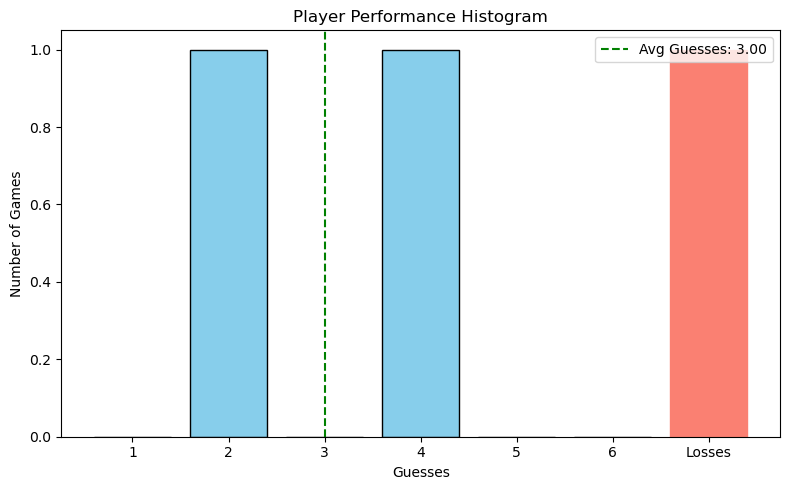

In [89]:
play_wordle()